## Download Book Details from a book store

In [129]:
import re
import pandas as pd
import requests
#Importing XML and HTML data
from lxml.html import parse
from urllib.request import urlopen
import bs4
import string
from PIL import Image
from io import BytesIO
from IPython.core.display import HTML
import base64

#### Find the number of books

In [2]:
url = 'https://www.pbookshop.com/catalogsearch/result/?cat=0&q=Statistics'

In [3]:
html_page = requests.get(url)
hp = html_page.text

In [4]:
soup = bs4.BeautifulSoup(hp)

In [5]:
selection = soup.find_all('select',{'onchange':'setLocation(this.value)'})

In [17]:
nr_of_books = max([int(x) for x in selection[2].text.replace('\n','').split()])
nr_of_books

60

#### A procedure to display an image

In [41]:
def display_an_image(link):
    response = requests.get(link)
    return Image.open(BytesIO(response.content))

In [18]:
url = 'https://www.pbookshop.com/catalogsearch/result/index/?cat=0&limit='+str(nr_of_books)+'&q=Statistics'
url

'https://www.pbookshop.com/catalogsearch/result/index/?cat=0&limit=60&q=Statistics'

In [19]:
html_page = requests.get(url)
hp = html_page.text

In [20]:
soup = bs4.BeautifulSoup(hp)

In [21]:
products_grids = soup.find_all('div',{'class':'products-grid'})

In [22]:
len(products_grids)

30

#### A procedure to obtain a book detail

In [118]:
def Obtain_Book_Detail(Book):
    Book_Detail = [x for x in Book.text.replace('\n','  ').split('  ') if len(x) > 0]
    if any('New Arrival' in x for x in Book_Detail):
        s=1
    else:
        s=0
    title = Book_Detail[s].strip()
    if any('Author' in x for x in Book_Detail):
        s=s+1
        Author = Book_Detail[s].strip().split(':')[1].split(';')
        Author = [x.strip() for x in Author]
    else:
        Author = ['unknown']
    if any('Published' in x for x in Book_Detail):
        s=s+1
        Published_yr = Book_Detail[s].strip().split(':')[1].strip()
    else:
        Published_yr = 'unknown'
    s=s+1
    Jurisdiction = Book_Detail[s].strip().split(':')[1].strip()
    if any('Save' in x for x in Book_Detail):
        s=s+2
        List_Price = float(Book_Detail[s].strip().split(' ')[1].replace(',','').strip())
        s=s+1
        Discount_Price = float(Book_Detail[s].strip().split(' ')[1].replace(',','').strip())
    else:
        s=s+1
        List_Price = float(Book_Detail[s].strip().split(' ')[1].replace(',','').strip())
        Discount_Price = List_Price
    link_to_pic = Book.find('img').get('src')
    photo = display_an_image(link_to_pic)
    return {'title':title,
            'Author':Author,
            'Published_yr':Published_yr,
            'Jurisdiction':Jurisdiction,
            'List_Price':List_Price,
            'Discount_Price':Discount_Price,
            'Photo': photo}  

In [119]:
Products = []
for t in products_grids:
    first_book = t.find('dl',{'class':'item first'})
    second_book = t.find('dl',{'class':'item last'})
    Products.append(Obtain_Book_Detail(first_book))
    Products.append(Obtain_Book_Detail(second_book))

In [120]:
len(Products)

60

In [121]:
Products_df = pd.DataFrame(Products)

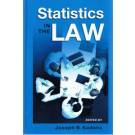

In [131]:
Products_df.Photo[0]

In [134]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im = im.convert('RGB')
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

,Author,Published_yr,Jurisdiction,List_Price,Discount_Price,Photo
title,,,,,,
Statistics in the Law,[Joseph Kadane],June 2008,U.S.,560.0,543.20,
Statistics for Compensation A Practical Guide to Compensation Analysis,[John H. Davis],March 2011,International,1280.0,1241.60,
Probability and Statistics for Finance,"[Svetlozar T. Rachev, Markus Hoechstoetter, Frank J. Fabozzi, CF, Sergio M. Focardi]",September 2010,International,950.0,921.50,
"Mathematics and Statistics for Financial Risk Management, 2nd Edition",[Michael B. Miller],December 2013,International,950.0,921.50,
An Essential Guide to Business Statistics,[Dawn A. Willoughby],April 2015,U.S.,1010.0,1010.00,
A Quantitative Approach to Commercial Damages Applying Statistics to the Measurement of Lost Profits,[Mark Filler],April 2012,International or US,1250.0,1212.50,
Sihombing's Hong Kong Company Law: Commentary on Cap 622 & 32 (Student Edition),[Judith Sihombing],January 2015,Hong Kong,438.0,175.20,
Sihombing's Hong Kong Company Law: Commentary on Cap 622 & 32,[Judith Sihombing],October 2014,Hong Kong,1980.0,792.00,
Bridging the Gender Pay Gap in Law Firms,[Stephanie Hawthorne],December 2018,International,607.5,607.50,

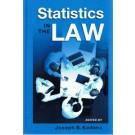
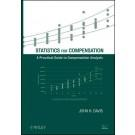
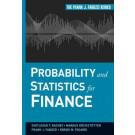
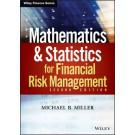
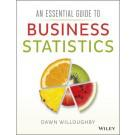
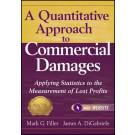
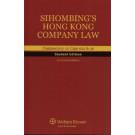
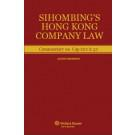
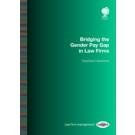
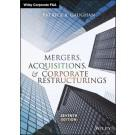
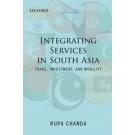
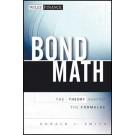
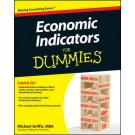
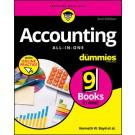
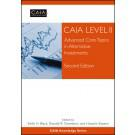
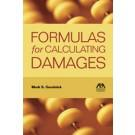
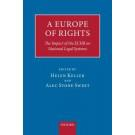
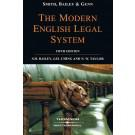
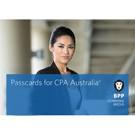
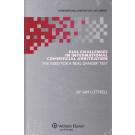
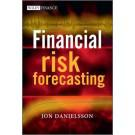
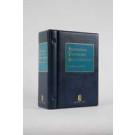
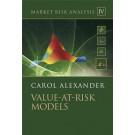
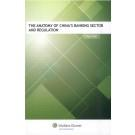
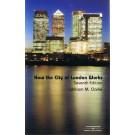
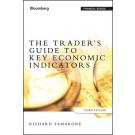
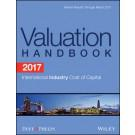
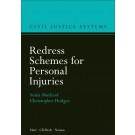
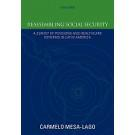
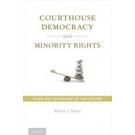
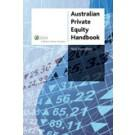
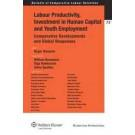
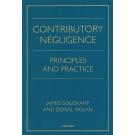
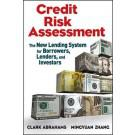
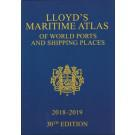
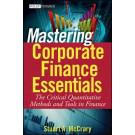
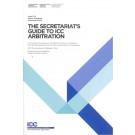
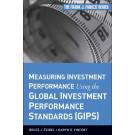
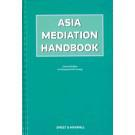
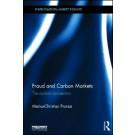
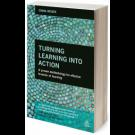
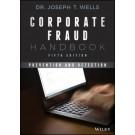
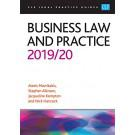
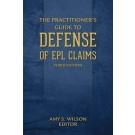
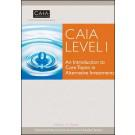
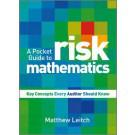
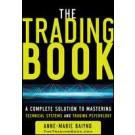
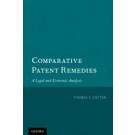
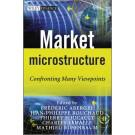
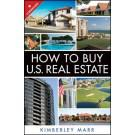
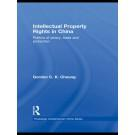
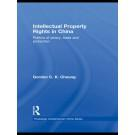
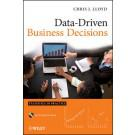
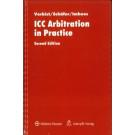
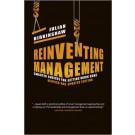
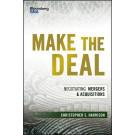
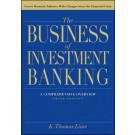
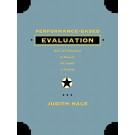
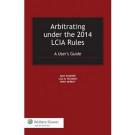
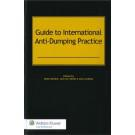

In [135]:
HTML(Products_df.set_index('title').to_html(formatters={'Photo': image_formatter}, escape=False))